In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
# nb_dir = os.path.split(os.getcwd())[0]
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)
    

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from wgand import EnsembleAnomalyDetector, PcaAnomalyDetector
from wgand import load_tissue_graph, get_gdf
from wgand.utils import precision_at_k, fit_embedding_model, get_metrics, get_disease_info_df, get_tissue_mapping_df

/home/kagandi/Projects/Tissue Networks/wgand/base_detector.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import networkx as nx
import pickle
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from karateclub.node_embedding.neighbourhood import Node2Vec
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [5]:
def predict_anom(clf, X, method="linear"):
    clf.fit(X)
    return clf.predict_proba(X,method=method)[:,1:]

In [6]:
tissue_path = Path("Tissue Networks/")
models_path = Path("models")
out_path = Path("out")

In [7]:
disease_info = get_disease_info_df("data/Disease_Info.csv")

In [8]:
tissue_mapping = get_tissue_mapping_df("data/tissue_mapping_new.csv",disease_info)

## Generate Embedding

In [9]:
from karateclub.node_embedding.neighbourhood import RandNE


In [10]:
emb_model = "RandNE"
if (models_path/f"{emb_model}.pkl").exists():
    print("Loading embeddings")
    edge_df = pd.read_pickle(models_path/f"{emb_model}.pkl")
else:
    tissue_name = tissue_mapping.iloc[0]["tissue_name_network_file"]
    tissue_disease_file_name = tissue_mapping.iloc[0]["tissue_name_disease_file"]
    g = load_tissue_graph(tissue_name, tissue_disease_file_name)
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
    edge_df = nx.convert_matrix.to_pandas_edgelist(g_num)
    edge_df["source"] = edge_df["source"].astype(int)
    edge_df["target"] = edge_df["target"].astype(int)
    edge_df = get_gdf(g)
    model = fit_embedding_model(g_num, RandNE)
    edge_df["features"] = edge_df.apply(lambda x: np.concatenate([model.get_embedding()[int(x["source"])],model.get_embedding()[int(x["target"])]]), axis=1)
    edge_df.to_pickle(models_path/f"{emb_model}.pkl")

Loading embeddings


# Baseline 1

In [18]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from wgand.utils import precision_at_k
from pyod.models.iforest import IForest
warnings.filterwarnings('ignore')
res = []
predictions = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    metrics_dict = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")

    metrics_dict["tissue_name"] = tissue_name
    # temp["Tissue Disease File"] = tissue_name_disease_file
    if not Path(f"models/weighted_node2vec{tissue_name}.feather").exists():
        raise LookupError
    else:
        node_df = pd.read_feather(f"models/weighted_node2vec{tissue_name}.feather")
        node_df["tissue_name"] = tissue_name
    node_df["gen_name"] = node_df["node"].apply(lambda x: g_num.nodes[x]['gen'])
    clf = IForest(n_jobs=-1, random_state=2)
    X = np.stack(node_df["features"].values)
    probs = predict_anom(clf,X) 
    node_df["proba"] = probs
    node_df = node_df.sort_values("proba",ascending=False)
    predictions.append(node_df.drop(columns="features"))


    metrics_dict["auc"] = roc_auc_score(node_df["disease"].values, clf.predict_proba(X)[:,1])
    metrics_dict["p@1"] = node_df.iloc[:1].disease.sum()
    metrics_dict["p@3"] = node_df.iloc[:3].disease.sum()/3
    metrics_dict["p@10"] = node_df.iloc[:10].disease.sum()/10
    metrics_dict["p@20"] = node_df.iloc[:20].disease.sum()/20
    metrics_dict["p@40"] = node_df.iloc[:40].disease.sum()/40
    res.append(metrics_dict.copy())       



  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [19]:
baseline1_res = pd.DataFrame(res)
baseline1_res.mean()

auc     0.518178
p@1     0.000000
p@3     0.000000
p@10    0.011765
p@20    0.014706
p@40    0.010294
dtype: float64

In [22]:
baseline1_res

,Tissue Network,Tissue Disease File,auc,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,Artery Aorta,0.462882,0,0.0,0.0,0.00,0.025
1,Brain Cerebellum,Brain Cerebellum,0.524130,0,0.0,0.0,0.00,0.000
2,Brain Cortex,Brain Cortex,0.534219,0,0.0,0.0,0.00,0.000
3,Brain Spinal cord cervical c 1,Spinal cord,0.524940,0,0.0,0.0,0.05,0.025
4,Heart Atrial Appendage,Heart Atrium,0.557211,0,0.0,0.0,0.00,0.000
5,Heart Left Ventricle,Heart Ventricle,0.542867,0,0.0,0.0,0.00,0.000
6,Liver,Liver,0.417830,0,0.0,0.0,0.00,0.000
7,Lung,Respiratory system Lung,0.524405,0,0.0,0.1,0.05,0.025
8,Muscle Skeletal,Skeletal muscle,0.542828,0,0.0,0.0,0.00,0.000
9,Nerve Tibial,Peripheral nerve,0.514526,0,0.0,0.0,0.00,0.000


In [21]:
baseline1_res.to_csv(out_path/"baseline1_res.csv", index=False)

In [38]:
pd.concat(predictions, ignore_index=True).to_feather(out_path/"baseline_node2vec_iforest_preds.feather")

In [68]:
baseline_preds = pd.read_feather(out_path/"baseline_node2vec_iforest_preds.feather")

In [27]:
baseline_preds = baseline_preds.rename(columns={"tissue_name":"Tissue Network", "disease":"is_labeled_disease", "proba": "abnormality_score"})
baseline_preds["Method"] = "Node2Vec + Iforest)"
baseline_preds = baseline_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [28]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(baseline_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [29]:
baseline_preds["P"] =list(pd.DataFrame(pk)["P"])
baseline_preds["K"] =list(pd.DataFrame(pk)["K"])

In [30]:
baseline_preds.reset_index(drop=True).to_feather(out_path/"baseline_node2vec_iforest_preds.feather")

# Baseline 2 ODDBall

In [24]:
oddball_path = Path("../oddball_py3/out")

In [25]:
from collections import defaultdict
g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
nx.write_edgelist(g_num, tissue_path/f"csv/{tissue_name}.csv", data=["weight"])
nodes_ids = list(g_num.nodes)
id_gene = {g_num.nodes[n]["gen"]: n for n in nodes_ids}
id_gene = defaultdict(lambda: -1, id_gene)
disease_info["node_id"] = disease_info.Gene_ID.apply(lambda x: id_gene[x])

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

res = []
oddball_predictions = []
for _, row in tqdm(tissue_mapping.iterrows()):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]

    oddball_res_path = next(oddball_path.glob(f"{tissue_name}_0_1.*"))
    oddball_res = pd.read_csv(oddball_res_path, sep="\s", names=["node_id", "score"])
    oddball_res = oddball_res.merge(disease_info[disease_info.Tissue==tissue_name_disease_file][["node_id","Disease_name"]], on="node_id", how="left")
    oddball_res["is_disease"] = oddball_res.Disease_name.apply(lambda x: not pd.isna(x))
    
    scores = oddball_res["score"].values
    scaler = MinMaxScaler().fit(scores.reshape(-1, 1))
    probs = scaler.transform(scores.reshape(-1, 1)).ravel().clip(0, 1)
    scores = oddball_res["score"].values
    
    metrics_dict = get_metrics(oddball_res.is_disease, probs)
    metrics_dict["tissue_name"] = tissue_name


    res.append(metrics_dict)
    oddball_res["tissue_name"] = tissue_name
    oddball_predictions.append(oddball_res)



0it [00:00, ?it/s]

In [28]:
oddball_res = pd.DataFrame(res)
oddball_res.mean()

AUC     0.591284
P@1     0.176471
P@3     0.078431
P@10    0.076471
P@20    0.052941
dtype: float64

In [29]:
oddball_res.to_csv(out_path/"oddball_res.csv", index=False)

In [62]:
oddball_preds = pd.concat(oddball_predictions, ignore_index=True)

In [61]:
oddball_preds.to_feather(out_path/"baseline_oddball_preds.feather")

In [31]:
oddball_preds = oddball_preds.rename(columns={"tissue_name":"Tissue Network", "is_disease":"is_labeled_disease", "score": "abnormality_score"})
oddball_preds["Method"] = "OddBall"
oddball_preds = oddball_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [32]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(oddball_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [33]:
oddball_preds["P"] =list(pd.DataFrame(pk)["P"])
oddball_preds["K"] =list(pd.DataFrame(pk)["K"])

In [34]:
oddball_preds.reset_index(drop=True).to_feather(out_path/"baseline_oddball_preds.feather")

# Ours

## Main (Ensemble)

In [14]:
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
res = []
df_wgand = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = EnsembleAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2), IForest(n_jobs=-1,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit(nodes)
  
    probs = nad.predict_node_proba(nodes)
    metrics_dict = get_metrics(y, probs)
    metrics_dict["tissue_name"] = tissue_name

    res.append(metrics_dict.copy())  
    df_wgand.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs, "is_labeled_disease":y}))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------


In [35]:
pd.DataFrame(res).mean()

auc         0.670080
p@1         0.529412
p@3         0.372549
p@10        0.252941
p@20        0.214706
p@anom      0.099098
anom      142.941176
dtype: float64

In [33]:
pd.DataFrame(res).to_csv(out_path/"wagnd.csv", index=False)

In [39]:
wgand_preds = pd.concat(df_wgand, ignore_index=True)
wgand_preds.to_feather(out_path/"wgand_preds.feather")

In [18]:
wgand_preds = wgand_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])

In [19]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(wgand_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [20]:
wgand_preds["P"] =list(pd.DataFrame(pk)["P"])
wgand_preds["K"] =list(pd.DataFrame(pk)["K"])

In [21]:
wgand_preds["Method"] = "WGAND (Ensemble)"


In [23]:
wgand_preds.reset_index(drop=True).to_feather(out_path/"wgand_preds.feather")

## Feature Comb

In [77]:
from wgand.base_detector import BaseDetector as WgandDetector
import pyod.models.combination as comb 
res = []
feature_comb_preds = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]

    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = WgandDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit(nodes)
  
    probs = nad.predict_feature_score(nodes)
    preds_df = pd.DataFrame({"node":nodes, "label":y, "feature_score":probs[:,0]})
    preds_df["tissue_name"] = tissue_name
    
    feature_comb_preds.append(preds_df)
    temp = get_metrics(y, probs)
    temp["tissue_name"] = tissue_name

    res.append(temp.copy())  
    # df_concat.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs, "is_labeled_disease":y}))


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [58]:
pd.DataFrame(res).mean()

auc         0.678703
p@1         0.294118
p@3         0.372549
p@10        0.223529
p@20        0.152941
p@anom      0.082182
anom      142.941176
dtype: float64

In [66]:
pd.DataFrame(res).to_csv(out_path/"feature_comb.csv", index=False)

In [59]:
feature_comb_preds = pd.concat(feature_comb_preds)

In [61]:
feature_comb_preds = feature_comb_preds.rename(columns={"feature_score":"abnormality_score",	"tissue_name":"Tissue Network", "label":"is_labeled_disease"})

In [62]:
feature_comb_preds = feature_comb_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [63]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(feature_comb_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [64]:
feature_comb_preds["Method"] = "Feature Mean"
feature_comb_preds["P"] =list(pd.DataFrame(pk)["P"])
feature_comb_preds["K"] =list(pd.DataFrame(pk)["K"])

In [68]:
feature_comb_preds.reset_index().to_feather(out_path/"feature_comb_preds.feather")

## PCA

In [173]:
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
res = []
df_pca = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = PcaAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    # nad.train_weight_classifier()
    nad.fit()
    probs = nad.predict_proba(nodes, method="inverse")

    temp = get_metrics(y, probs)
    temp["tissue_name"] = tissue_name
    res.append(temp.copy())  
    df_pca.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs[:,0], "is_labeled_disease":y}))


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------


TypeError: super(type, obj): obj must be an instance or subtype of type

In [17]:
pd.DataFrame(res).mean()

auc         0.637900
p@1         0.352941
p@3         0.313725
p@10        0.194118
p@20        0.155882
p@anom      0.088132
anom      142.941176
dtype: float64

In [18]:
pd.DataFrame(res).to_csv(out_path/"pca.csv", index=False)

In [19]:
df_pca = pd.concat(df_pca, ignore_index=True)

In [20]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(df_pca.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
df_pca["Method"] = "PCA"
df_pca = df_pca.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_pca["P"] =list(pd.DataFrame(pk)["P"])
df_pca["K"] =list(pd.DataFrame(pk)["K"])

In [22]:
df_pca.reset_index().to_feather(out_path/"pca_preds.feather")

## IForest

In [117]:
from pyod.models.iforest import IForest
res = []
df_iforest = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    
    clf = IForest(n_jobs=-1, random_state=2)
         
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue

    nad = EnsembleAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2), IForest(n_jobs=-1,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit(nodes)
  
    X = nad.get_node_training_data(nodes)


    probs = predict_anom(clf,X) 

    temp = get_metrics(y, probs)
    temp["tissue_name"]  = tissue_name

    res.append(temp.copy())  
    df_iforest.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs[:,0], "is_labeled_disease":y}))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [118]:
pd.DataFrame(res).mean()

auc         0.619919
p@1         0.235294
p@3         0.215686
p@10        0.194118
p@20        0.158824
p@anom      0.082342
anom      142.941176
dtype: float64

In [119]:
pd.DataFrame(res).to_csv(out_path/"iforest.csv", index=False)

In [32]:
df_iforest = pd.concat(df_iforest, ignore_index=True)

In [33]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(df_iforest.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [34]:
df_iforest["Method"] = "IForest"
df_iforest = df_iforest.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_iforest["P"] =list(pd.DataFrame(pk)["P"])
df_iforest["K"] =list(pd.DataFrame(pk)["K"])

In [35]:
df_iforest.reset_index().to_feather(out_path/"iforest_preds.feather")

# Single Feature

In [95]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
warnings.filterwarnings('ignore')
res = []
res_auc = []

with tqdm(total=(len(tissue_mapping))) as pbar:
    for _, row in tissue_mapping.iterrows():
        tissue_name = row["tissue_name_network_file"]
        tissue_name_disease_file = row["tissue_name_disease_file"]

        try:
            g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)


        except KeyError:
            print(f"{tissue_name} not found in disease info")
            continue

        nad = EnsembleAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2), IForest(n_jobs=-1,random_state=2))
        nad.set_gdf_features(edge_df["features"])
        nad.fit(nodes)
        
        df_agg = nad.get_node_features()
        nodes = list(df_agg.node_name)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]  
        df_agg["y"] = y
        for feature in df_agg.columns.values[:-3]:
            temp = {"tissue_name": tissue_name}

            df_agg = df_agg.sort_values(feature,ascending=False)
            temp["feature"] = feature
            temp["auc"] = roc_auc_score(df_agg.y ,df_agg[feature])
            res_auc.append(temp.copy())


            pk = precision_all_k(df_agg.y, df_agg[feature])
            pk = [{**{"tissue_name":tissue_name,"feature": feature},**line} for line in pk]
            res += pk
        pbar.update(1)
        

  0%|          | 0/17 [00:00<?, ?it/s]

In [99]:
auc_single = pd.DataFrame(res_auc).groupby("feature").mean()
auc_single.to_csv(out_path/"auc_single.csv")
auc_single = auc_single.sort_values("auc")

In [102]:
features_predict = pd.DataFrame(res)

In [108]:
features_predict.to_feather(out_path/"features_predict.feather")

# Graphs

In [25]:
res = []
with tqdm(total=(len(tissue_mapping))) as pbar:
    for _, line in tissue_mapping.iterrows():
        tissue_name = line["tissue_name_network_file"]
        tissue_name_disease_file = line["tissue_name_disease_file"]

        try:
            g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
        except KeyError:
            print(f"{tissue_name} not found in disease info")
            continue
        disease_num = len([1 for n in g.nodes if g.nodes[n]])
        for k in range(1,g.number_of_nodes()+1):
            res.append({"tissue_name":tissue_name,"feature": "Random", "K": k , "P": disease_num/g.number_of_nodes()})
        pbar.update(1)
df_random =pd.DataFrame(res)
df_random = df_random.rename(columns={"tissue_name":"Tissue Network","feature":"Method"})

  0%|          | 0/17 [00:00<?, ?it/s]

## P@K Method vs Baseline

In [24]:
wgand_preds = pd.read_feather(out_path/"wgand_preds.feather")
pca_preds = pd.read_feather(out_path/"pca_preds.feather")
iforest_preds = pd.read_feather(out_path/"iforest_preds.feather")
feature_comb_preds = pd.read_feather(out_path/"feature_comb_preds.feather")
oddball_preds = pd.read_feather(out_path/"baseline_oddball_preds.feather")
baseline_preds = pd.read_feather(out_path/"baseline_node2vec_iforest_preds.feather")

In [27]:
pca_preds["Method"] = "WGAND (PCA)"
iforest_preds["Method"] = "WGAND (IForest)"
wgand_preds["Method"] = "WGAND (Ensemble)"
feature_comb_preds["Method"] = "WGAND (Feature`s Mean)"
oddball_preds["Method"] = "OddBall"
baseline_preds["Method"] = "Node2Vec + IForest"


In [28]:
df_methods = pd.concat([wgand_preds, baseline_preds, oddball_preds, df_random, feature_comb_preds, pca_preds], ignore_index=True)

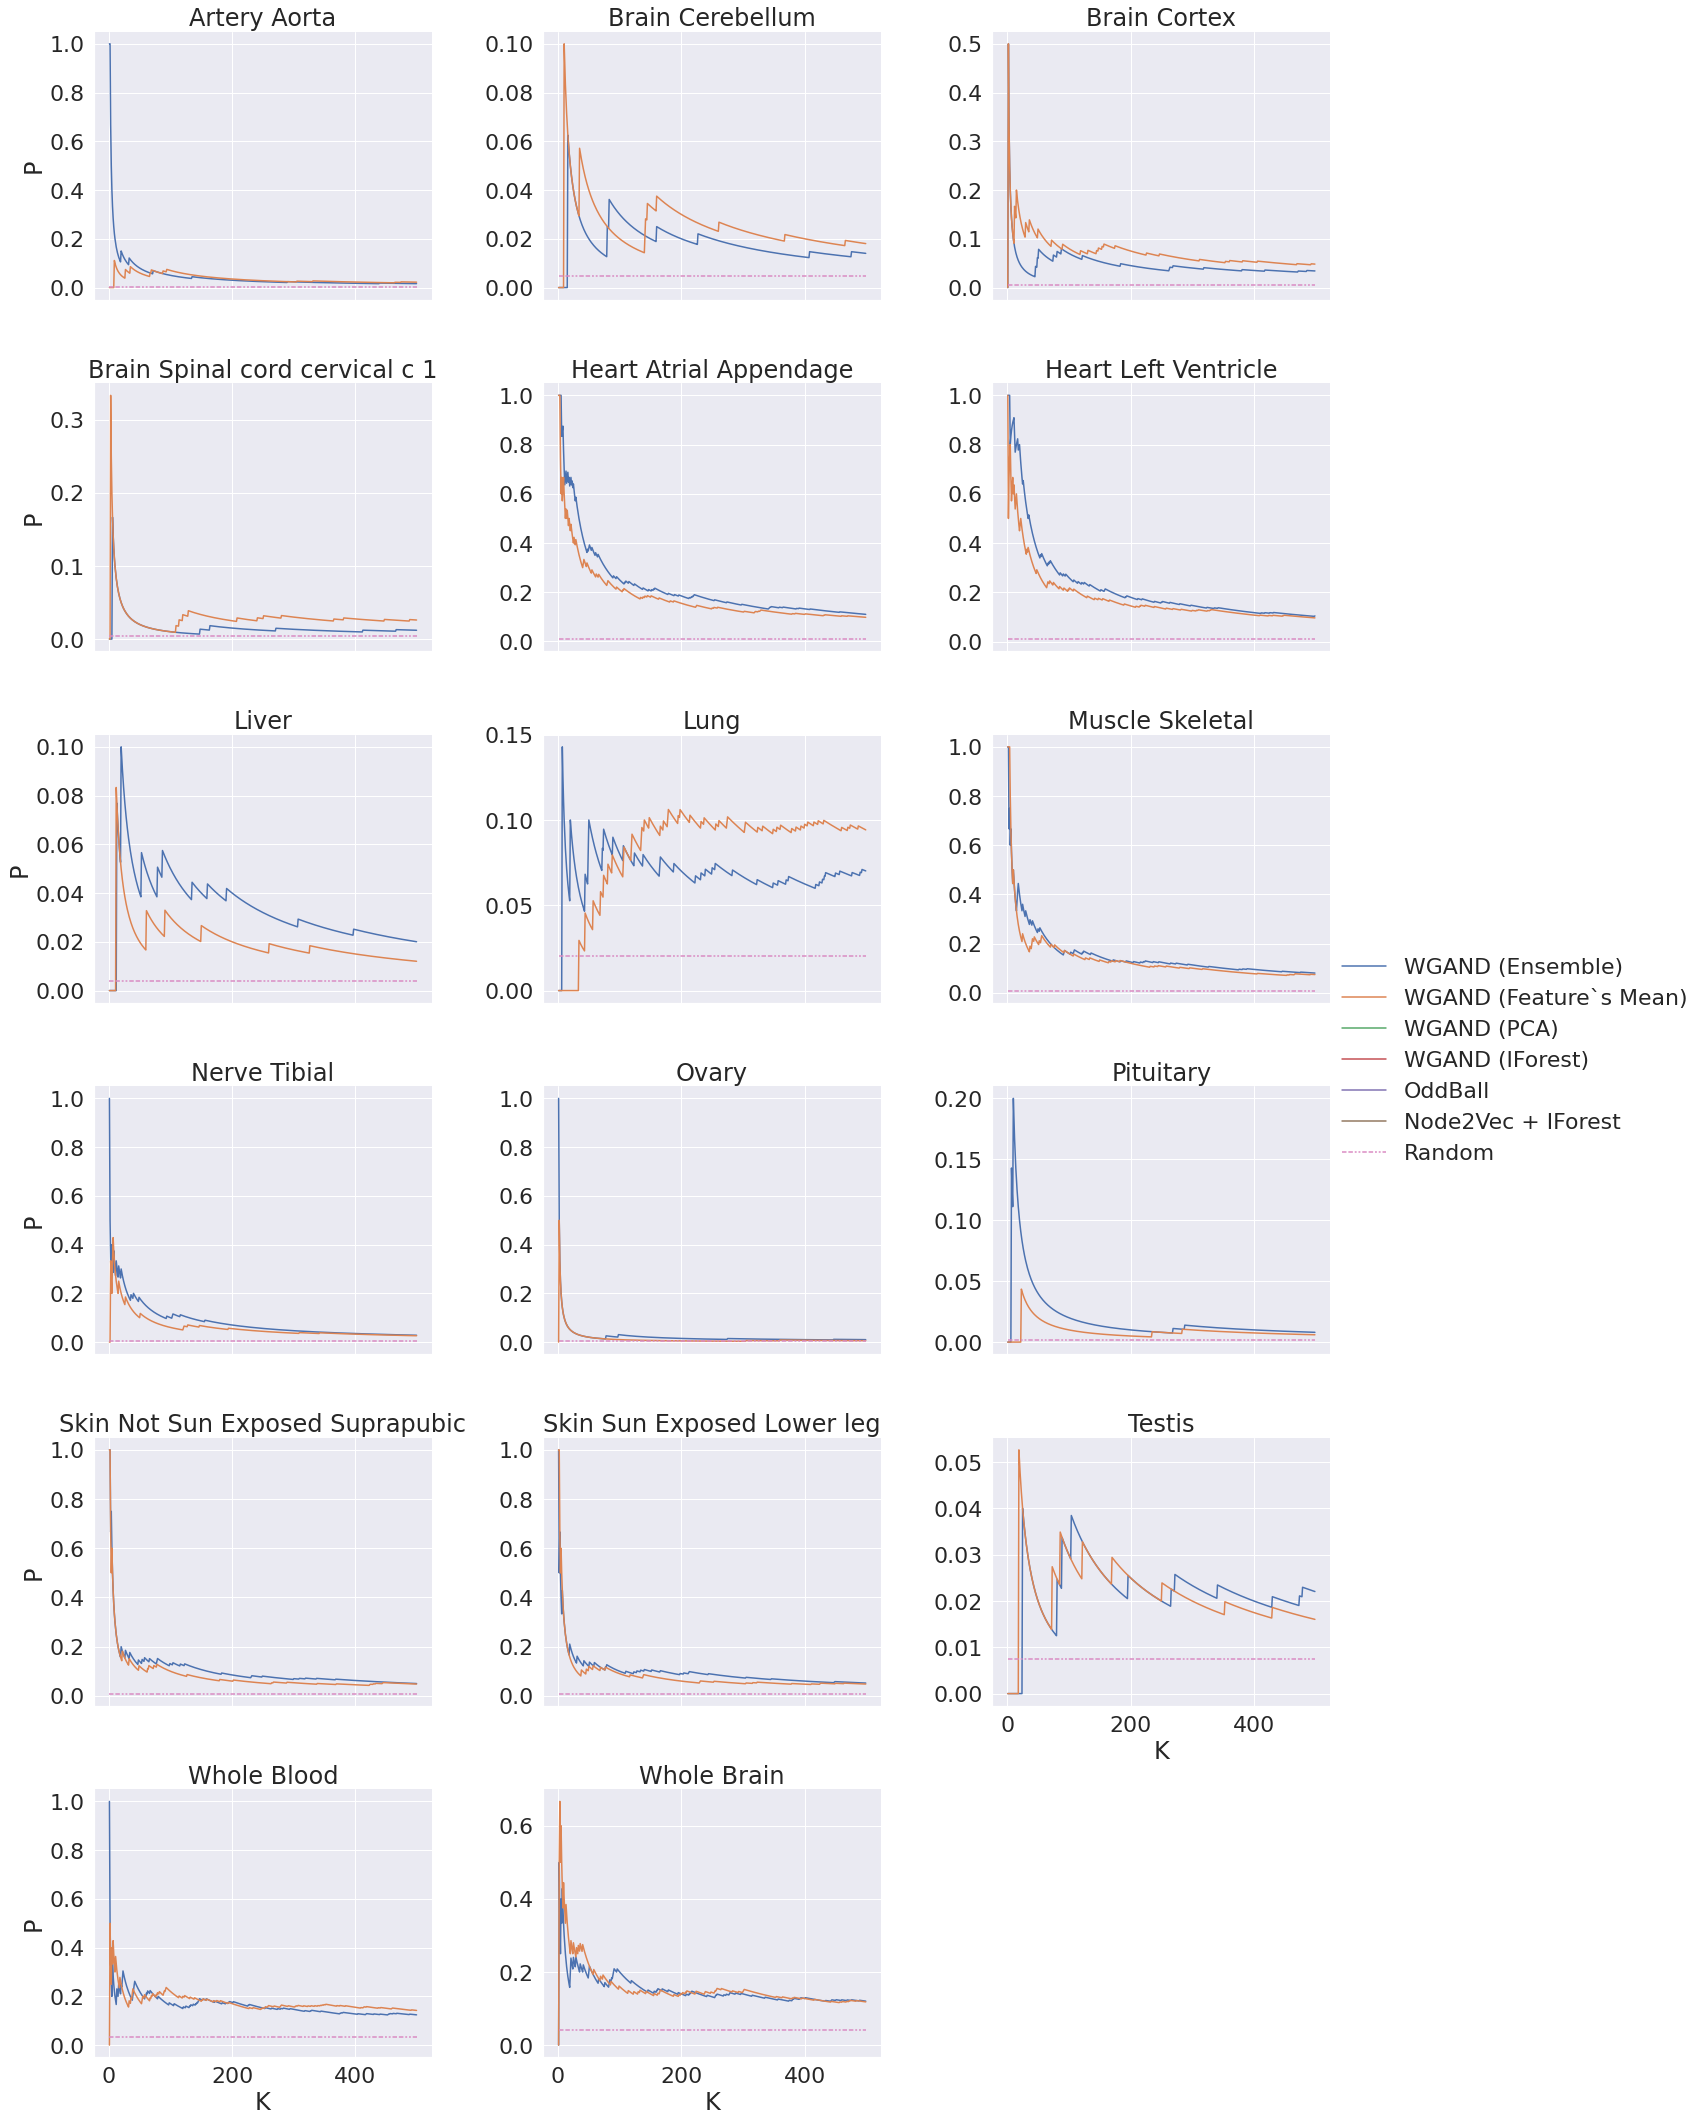

In [37]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=2)
style = {f:"" for f in set(df_methods["Method"])}
style["Random"] =  (3, 1.25, 3, 1.25, 1.25, 1.25, 1.25, 1.25)
hue_order = ["WGAND (Ensemble)", "WGAND (Feature`s Mean)", "WGAND (PCA)", "WGAND (IForest)", "OddBall", "Node2Vec + IForest", "Random"]
g = sns.relplot(data=df_methods[df_methods.K<500],x="K", y="P", hue="Method", col="Tissue Network", kind="line",col_wrap=3, dashes=style,style="Method", hue_order=hue_order, facet_kws={'sharey': False, 'sharex': True})

ax1 = g.fig.axes[0]
h,l =  ax1.get_legend_handles_labels()
g.legend.remove()
g.add_legend(dict(zip(l[0:7], h[0:7])))

for ax in g.axes:
    ax.set_title(ax.title.get_text().replace('Tissue Network = ', ""))
g.savefig("figures/p@k_clf.png", dpi=300)

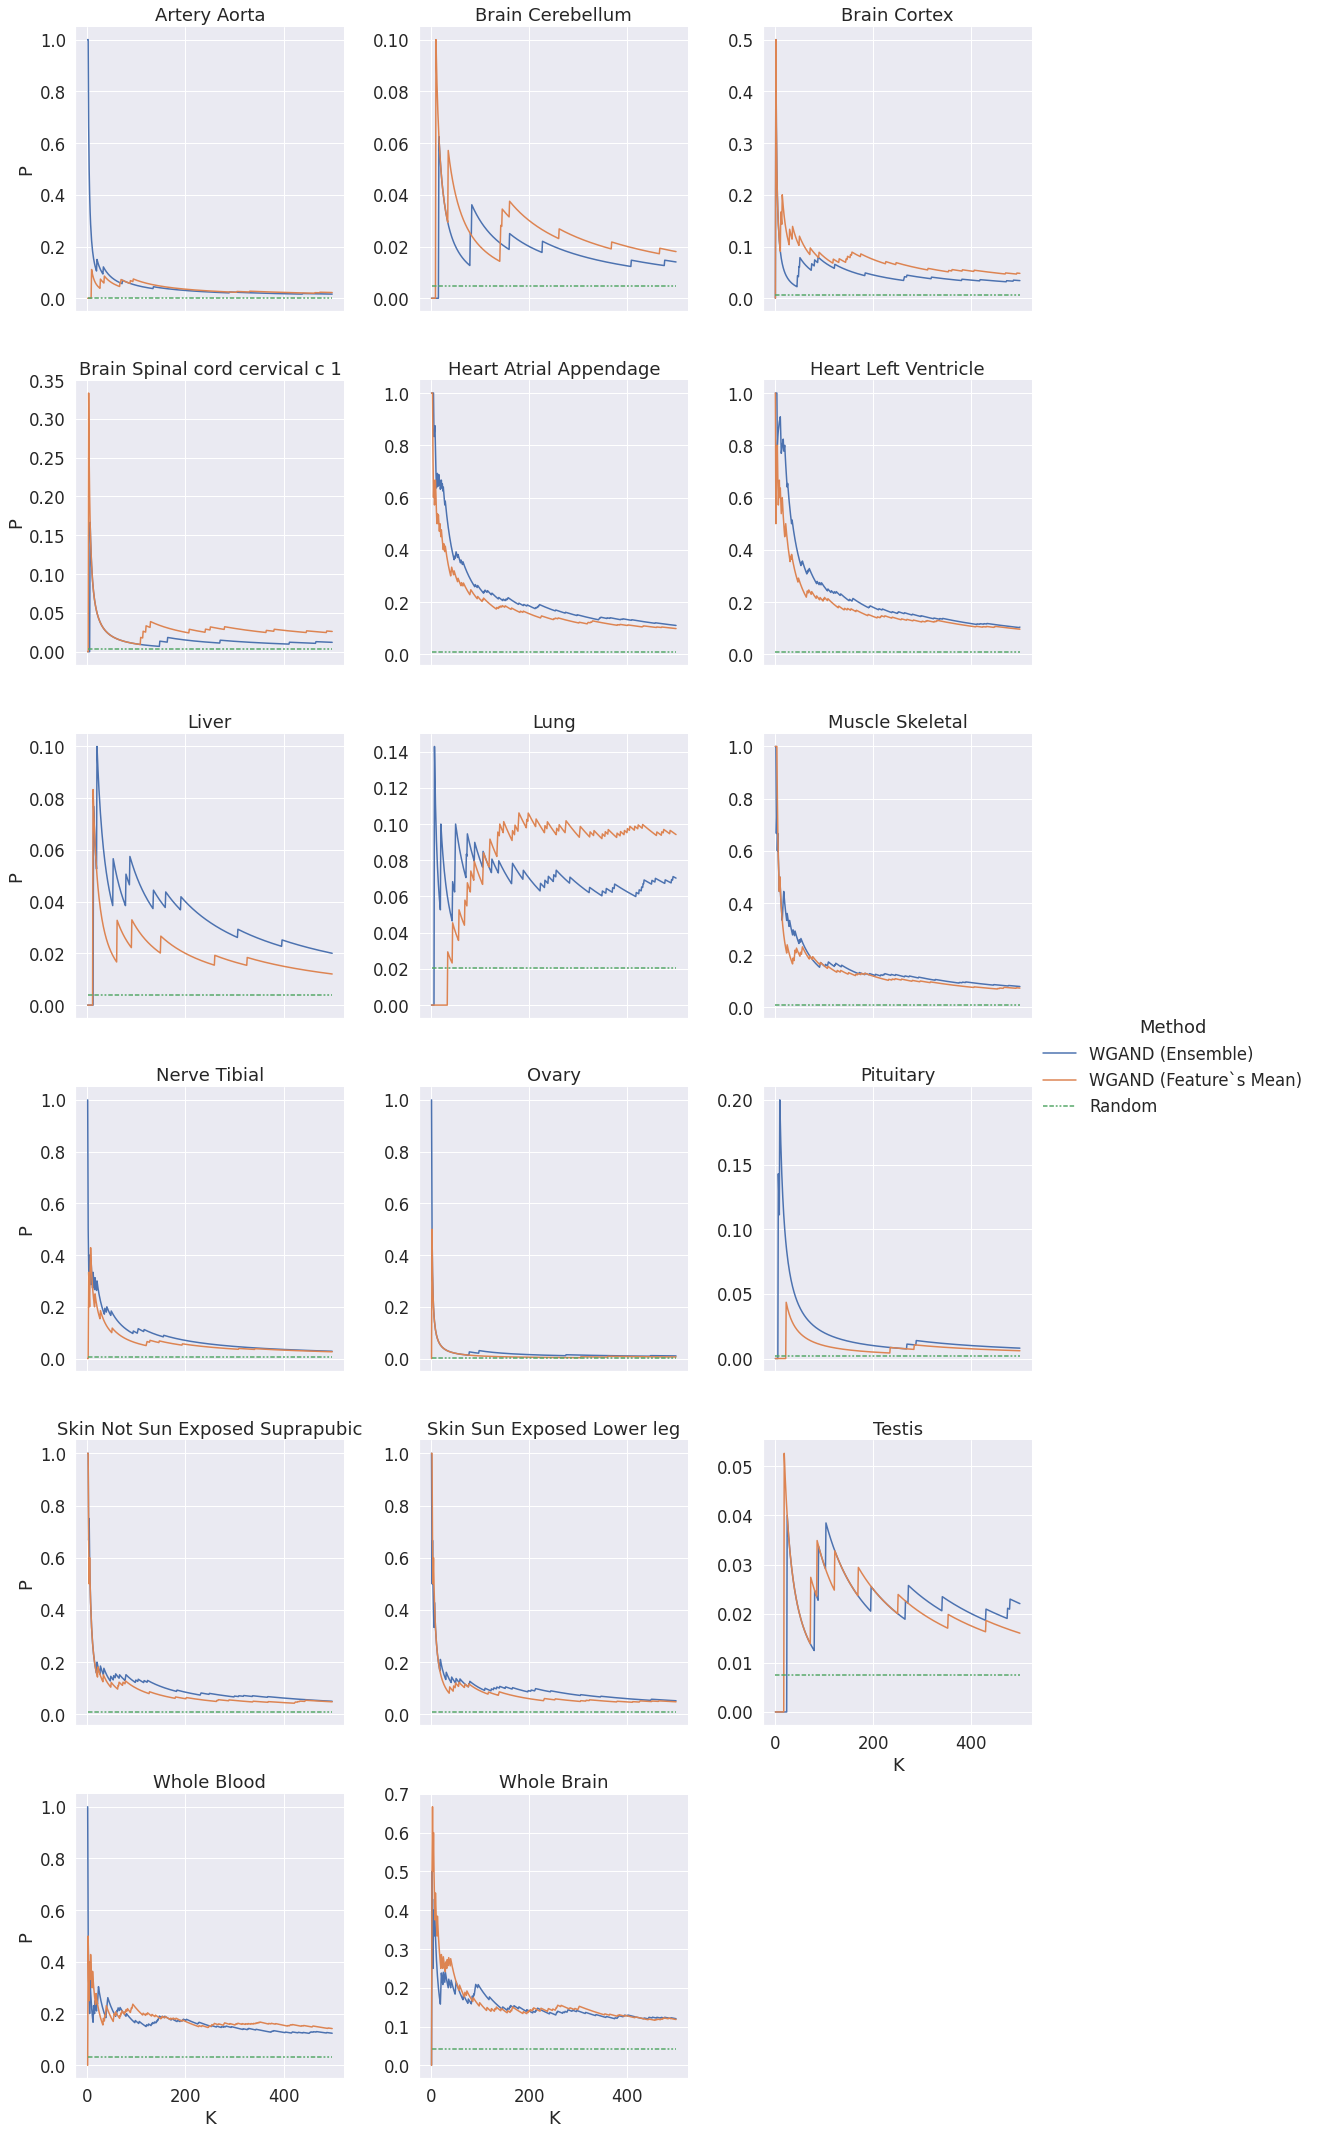

In [39]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.5)
df_methods = pd.concat([wgand_preds, feature_comb_preds,  df_random], ignore_index=True)
style = {f:"" for f in set(df_methods["Method"])}
style["Random"] =  (3, 1.25, 3, 1.25, 1.25, 1.25, 1.25, 1.25)
g = sns.relplot(data=df_methods[df_methods.K<500],x="K", y="P", hue="Method", col="Tissue Network", kind="line",col_wrap=3, dashes=style,style="Method",  facet_kws={'sharey': False, 'sharex': True})
for ax in g.axes:
    ax.set_title(ax.title.get_text().replace('Tissue Network = ', ""))

## P@K Single Features

In [54]:
features_predict = pd.read_feather(out_path/"features_predict.feather")

In [55]:
feature_name_map =  {'abs_diff_mean':"Mean Absolute Error",
                     'abs_diff_median':"Median Absolute Error",
                     'abs_diff_sem':"Standard Absolute Error of the Mean",
                     'abs_diff_std':"Absolute Error Standard Deviation",
                     'abs_diff_sum':"Sum of Absolute Errors",
                     'diff_mean':"Mean Error",
                     'diff_median':"Median Error",
                     'diff_sem':"SEM",
                     'diff_std':"Error Standard Deviation",
                     'diff_sum':"Sum of Errors",
                     'random': "Random"}

In [56]:
for f_old, f_new in feature_name_map.items():
    features_predict.feature.replace(f_old, f_new, inplace=True)

In [57]:
features_predict = features_predict.rename(columns={"tissue_name":"Tissue Network", "feature":"Feature"})

In [58]:
df_random

,Tissue Network,Method,K,P
0,Artery Aorta,Random,1,0.001701
1,Artery Aorta,Random,2,0.001701
2,Artery Aorta,Random,3,0.001701
3,Artery Aorta,Random,4,0.001701
4,Artery Aorta,Random,5,0.001701
...,...,...,...,...
229886,Whole Brain,Random,13519,0.041707
229887,Whole Brain,Random,13520,0.041707
229888,Whole Brain,Random,13521,0.041707
229889,Whole Brain,Random,13522,0.041707


In [59]:
features_predict_pk =  features_predict.append(df_random.rename(columns={"Method":"Feature"}), ignore_index=True)

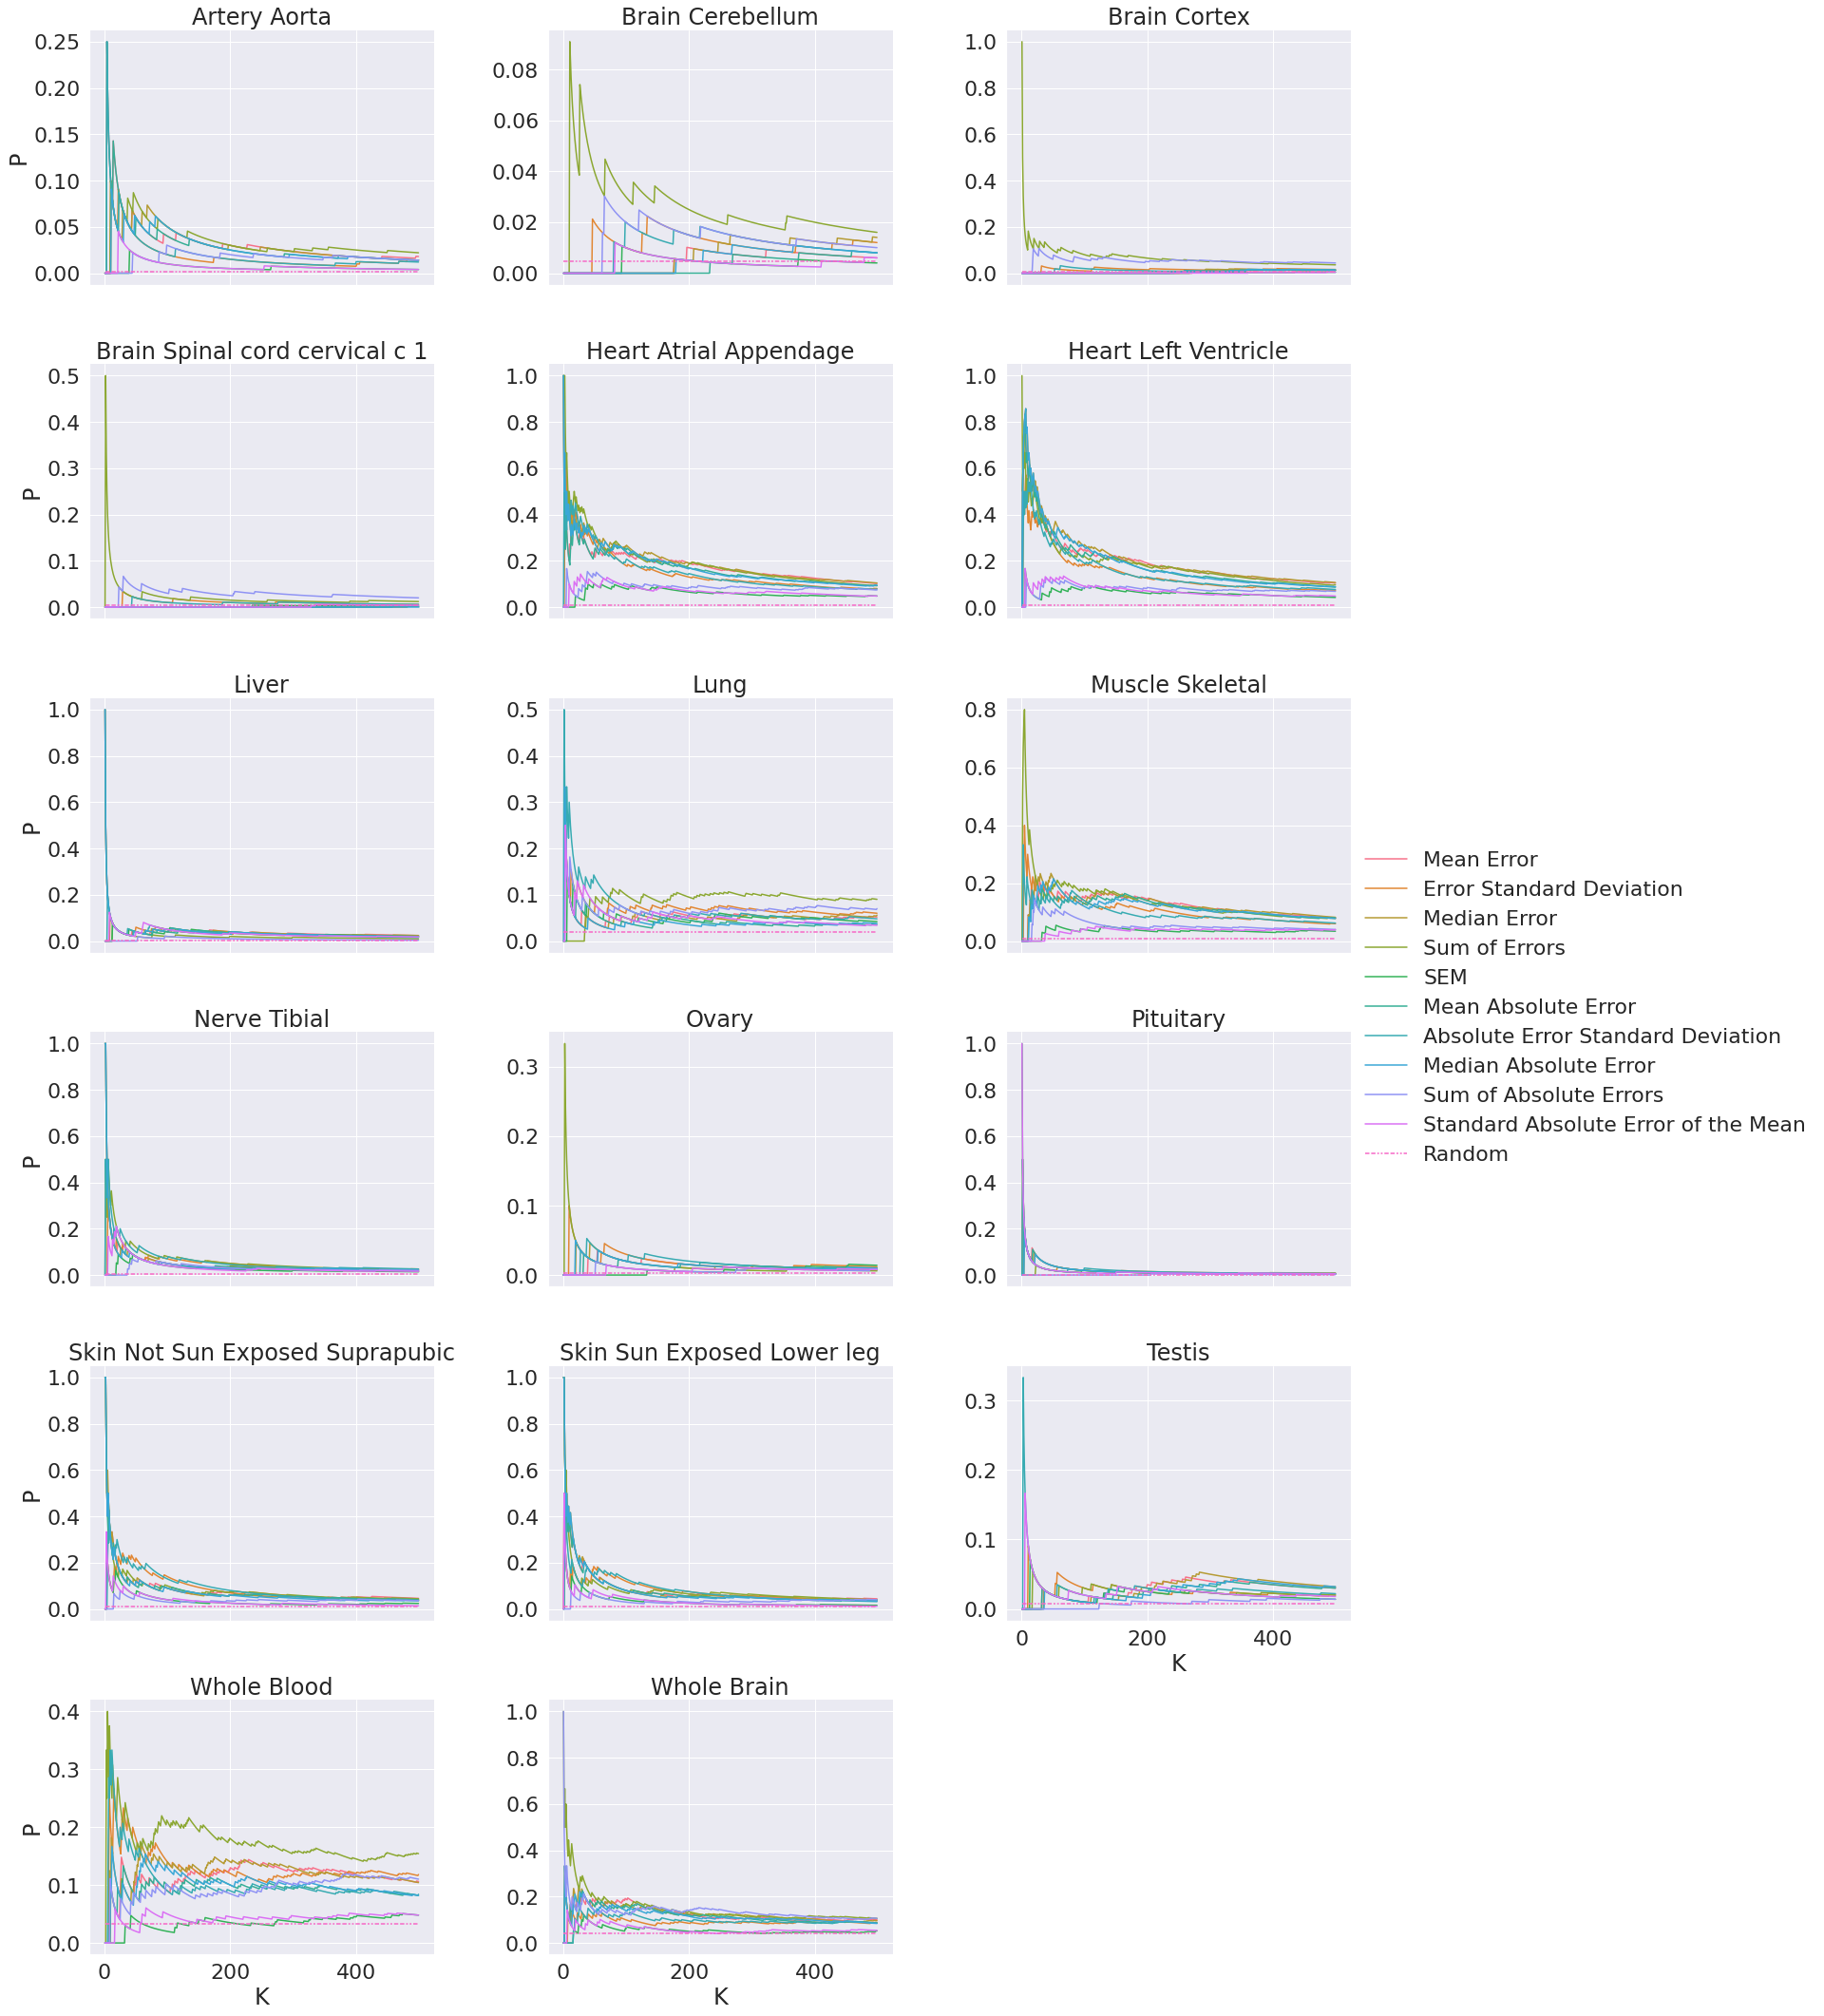

In [60]:
sns.set(font_scale=2)
style = {f:"" for f in set(features_predict_pk["Feature"])}
style["Random"] =  (3, 1.25, 3, 1.25, 1.25, 1.25, 1.25, 1.25)
g= sns.relplot(data=features_predict_pk[features_predict_pk["K"]<500],x="K", y="P",hue="Feature", col="Tissue Network", kind="line",col_wrap=3, dashes=style, style="Feature" , facet_kws={'sharey': False, 'sharex': True})
ax1 = g.fig.axes[0]
h,l =  ax1.get_legend_handles_labels()
g.legend.remove()
g.add_legend(dict(zip(l[0:13], h[0:13])))
for ax in g.axes:
    # ax.set_ylabel("Face-ism Index")
    # ax.set_xlabel("Century")
    ax.set_title(ax.title.get_text().replace('Tissue Network = ', ""))
g.savefig("figures/p@k.png", dpi=300)

In [63]:
feature_eval_tbl = features_predict[features_predict.K.isin([1,3,10,20])].pivot(index="Tissue Network", columns=["Feature", "K"], values="P")
feature_eval_tbl

Feature                         Mean Error                       \
K                                       1         3    10    20   
Tissue Network                                                    
Artery Aorta                           0.0  0.000000  0.1  0.10   
Brain Cerebellum                       0.0  0.000000  0.0  0.00   
Brain Cortex                           0.0  0.000000  0.0  0.00   
Brain Spinal cord cervical c 1         0.0  0.000000  0.0  0.00   
Heart Atrial Appendage                 1.0  0.333333  0.2  0.35   
Heart Left Ventricle                   0.0  0.666667  0.6  0.50   
Liver                                  1.0  0.333333  0.1  0.05   
Lung                                   0.0  0.333333  0.1  0.05   
Muscle Skeletal                        0.0  0.000000  0.0  0.15   
Nerve Tibial                           1.0  0.666667  0.2  0.10   
Ovary                                  0.0  0.000000  0.0  0.00   
Pituitary                              0.0  0.000000  0.1  0.10   
Skin Not Sun Exposed Suprapubic        1.0  0.666667  0.3  0.20   
Skin Sun Exposed Lower leg             1.0  0.666667  0.4  0.25   
Testis                                 0.0  0.000000  0.0  0.00   
Whole Blood                            0.0  0.000000  0.1  0.05   
Whole Brain                            0.0  0.333333  0.1  0.15   

Feature                         Error Standard Deviation                       \
K                                                     1         3    10    20   
Tissue Network                                                                  
Artery Aorta                                         0.0  0.000000  0.1  0.05   
Brain Cerebellum                                     0.0  0.000000  0.0  0.00   
Brain Cortex                                         0.0  0.000000  0.0  0.00   
Brain Spinal cord cervical c 1                       0.0  0.000000  0.0  0.00   
Heart Atrial Appendage                               0.0  0.333333  0.4  0.40   
Heart Left Ventricle                                 0.0  0.333333  0.4  0.40   
Liver                                                0.0  0.000000  0.1  0.05   
Lung                                                 0.0  0.333333  0.1  0.10   
Muscle Skeletal                                      0.0  0.000000  0.3  0.20   
Nerve Tibial                                         0.0  0.000000  0.2  0.15   
Ovary                                                0.0  0.000000  0.1  0.05   
Pituitary                                            0.0  0.333333  0.1  0.05   
Skin Not Sun Exposed Suprapubic                      0.0  0.000000  0.1  0.20   
Skin Sun Exposed Lower leg                           0.0  0.333333  0.1  0.15   
Testis                                               0.0  0.000000  0.0  0.05   
Whole Blood                                          0.0  0.000000  0.2  0.20   
Whole Brain                                          0.0  0.000000  0.1  0.10   

Feature                         Median Error            ...  \
K                                         1         3   ...   
Tissue Network                                          ...   
Artery Aorta                             0.0  0.000000  ...   
Brain Cerebellum                         0.0  0.000000  ...   
Brain Cortex                             0.0  0.000000  ...   
Brain Spinal cord cervical c 1           0.0  0.000000  ...   
Heart Atrial Appendage                   1.0  0.666667  ...   
Heart Left Ventricle                     0.0  0.666667  ...   
Liver                                    1.0  0.333333  ...   
Lung                                     0.0  0.333333  ...   
Muscle Skeletal                          0.0  0.000000  ...   
Nerve Tibial                             1.0  0.666667  ...   
Ovary                                    0.0  0.000000  ...   
Pituitary                                0.0  0.000000  ...   
Skin Not Sun Exposed Suprapubic          1.0  0.666667  ...   
Skin Sun Exposed Lower leg    

In [69]:
feature_eval_tbl.loc["Average"] = feature_eval_tbl.mean()

In [77]:
feature_eval_tbl

Feature                         Mean Error                                \
K                                      P@1       P@3      P@10      P@20   
Tissue Network                                                             
Artery Aorta                      0.000000  0.000000  0.100000  0.100000   
Brain Cerebellum                  0.000000  0.000000  0.000000  0.000000   
Brain Cortex                      0.000000  0.000000  0.000000  0.000000   
Brain Spinal cord cervical c 1    0.000000  0.000000  0.000000  0.000000   
Heart Atrial Appendage            1.000000  0.333333  0.200000  0.350000   
Heart Left Ventricle              0.000000  0.666667  0.600000  0.500000   
Liver                             1.000000  0.333333  0.100000  0.050000   
Lung                              0.000000  0.333333  0.100000  0.050000   
Muscle Skeletal                   0.000000  0.000000  0.000000  0.150000   
Nerve Tibial                      1.000000  0.666667  0.200000  0.100000   
Ovary                             0.000000  0.000000  0.000000  0.000000   
Pituitary                         0.000000  0.000000  0.100000  0.100000   
Skin Not Sun Exposed Suprapubic   1.000000  0.666667  0.300000  0.200000   
Skin Sun Exposed Lower leg        1.000000  0.666667  0.400000  0.250000   
Testis                            0.000000  0.000000  0.000000  0.000000   
Whole Blood                       0.000000  0.000000  0.100000  0.050000   
Whole Brain                       0.000000  0.333333  0.100000  0.150000   
Average                           0.294118  0.235294  0.135294  0.120588   

Feature                         Error Standard Deviation                      \
K                                                    P@1       P@3      P@10   
Tissue Network                                                                 
Artery Aorta                                         0.0  0.000000  0.100000   
Brain Cerebellum                                     0.0  0.000000  0.000000   
Brain Cortex                                         0.0  0.000000  0.000000   
Brain Spinal cord cervical c 1                       0.0  0.000000  0.000000   
Heart Atrial Appendage                               0.0  0.333333  0.400000   
Heart Left Ventricle                                 0.0  0.333333  0.400000   
Liver                                                0.0  0.000000  0.100000   
Lung                                                 0.0  0.333333  0.100000   
Muscle Skeletal                                      0.0  0.000000  0.300000   
Nerve Tibial                                         0.0  0.000000  0.200000   
Ovary                                                0.0  0.000000  0.100000   
Pituitary                                            0.0  0.333333  0.100000   
Skin Not Sun Exposed Suprapubic                      0.0  0.000000  0.100000   
Skin Sun Exposed Lower leg                           0.0  0.333333  0.100000   
Testis                                               0.0  0.000000  0.000000   
Whole Blood                                          0.0  0.000000  0.200000   
Whole Brain                                          0.0  0.000000  0.100000   
Average                                              0.0  0.098039  0.135294   

Feature                                   Median Error            ...  \
K                                    P@20          P@1       P@3  ...   
Tissue Network                                                    ...   
Artery Aorta                     0.050000     0.000000  0.000000  ...   
Brain Cerebellum                 0.000000     0.000000  0.000000  ...   
Brain Cortex                     0.000000     0.000000  0.000000  ...   
Brain Spinal cord cervical c 1   0.000000     0.000000  0.000000  ...   
Heart Atrial Appendage           0.400000     1.000000  0.666667  ...   
Heart Left Ventricle             0.400000     0.000000  0.666667  ...   
Liver                            0.050000     1.000000  0.333333 

In [76]:
feature_eval_tbl.columns.set_levels(['P@1','P@3','P@10', "P@20"],level=1, inplace=True)



In [79]:
feature_eval_tbl.to_latex("tables/feature_eval_tbl.tex", float_format="%.2f")

In [93]:
feature_eval_tbl.loc[:, (slice(None), 'P@10')].T.max()

Tissue Network
Artery Aorta                       0.1
Brain Cerebellum                   0.0
Brain Cortex                       0.1
Brain Spinal cord cervical c 1     0.1
Heart Atrial Appendage             0.5
Heart Left Ventricle               0.7
Liver                              0.1
Lung                               0.3
Muscle Skeletal                    0.4
Nerve Tibial                       0.3
Ovary                              0.1
Pituitary                          0.1
Skin Not Sun Exposed Suprapubic    0.3
Skin Sun Exposed Lower leg         0.4
Testis                             0.1
Whole Blood                        0.3
Whole Brain                        0.4
Average                            0.2
dtype: float64

## Box Plots

In [26]:
wgand = pd.read_csv(out_path/"wagnd.csv")
feature_comb = pd.read_csv(out_path/"feature_comb.csv")
pca = pd.read_csv(out_path/"pca.csv")
iforest = pd.read_csv(out_path/"iforest.csv")
oddball = pd.read_csv(out_path/"oddball_res.csv")
baseline = pd.read_csv(out_path/"baseline1_res.csv")

In [172]:
wgand

,tissue_name,auc,p@1,p@3,p@10,p@20,p@anom,anom
0,Artery Aorta,0.825966,1.0,0.666667,0.2,0.15,0.130435,23
1,Brain Cerebellum,0.562351,0.0,0.000000,0.0,0.05,0.015385,65
2,Brain Cortex,0.717616,0.0,0.333333,0.1,0.05,0.064935,77
3,Brain Spinal cord cervical c 1,0.711535,0.0,0.000000,0.1,0.05,0.020833,48
4,Heart Atrial Appendage,0.778214,1.0,1.000000,0.7,0.65,0.218045,133
5,Heart Left Ventricle,0.762020,1.0,1.000000,0.9,0.80,0.224638,138
6,Liver,0.549319,0.0,0.000000,0.0,0.10,0.056604,53
7,Lung,0.691774,0.0,0.000000,0.1,0.10,0.069343,274
8,Muscle Skeletal,0.733701,1.0,0.666667,0.5,0.40,0.157025,121
9,Nerve Tibial,0.632526,1.0,0.333333,0.3,0.30,0.116883,77


In [139]:
pca

,tissue_name,auc,p@1,p@3,p@10,p@20,p@anom,anom
0,Artery Aorta,0.815797,0.0,0.000000,0.1,0.05,0.086957,23
1,Brain Cerebellum,0.619709,0.0,0.000000,0.0,0.05,0.030769,65
2,Brain Cortex,0.662054,1.0,0.333333,0.1,0.15,0.090909,77
3,Brain Spinal cord cervical c 1,0.608301,0.0,0.333333,0.1,0.05,0.020833,48
4,Heart Atrial Appendage,0.683360,1.0,0.666667,0.5,0.45,0.210526,133
5,Heart Left Ventricle,0.693230,1.0,0.666667,0.5,0.50,0.210145,138
6,Liver,0.573061,0.0,0.000000,0.0,0.05,0.018868,53
7,Lung,0.634264,0.0,0.000000,0.0,0.00,0.102190,274
8,Muscle Skeletal,0.728981,0.0,0.666667,0.4,0.25,0.173554,121
9,Nerve Tibial,0.527235,0.0,0.333333,0.3,0.20,0.077922,77


In [41]:
baseline = baseline.rename(columns={"Tissue Network": "tissue_name"})
for col in oddball.columns:
    oddball = oddball.rename(columns={col: col.lower()})


In [42]:
wgand["Method"] = "WGAND (Ensemble)"
feature_comb["Method"] = "WGAND (Feature`s Mean)"
pca["Method"] = "WGAND (PCA)"
iforest["Method"] = "WGAND (IForest)"
oddball["Method"] = "OddBall"
baseline["Method"] = "Node2Vec + IForest"

In [97]:
res_df = pd.concat([wgand, feature_comb, iforest, pca, oddball, baseline], ignore_index=True)
res_df = pd.concat([wgand, feature_comb, iforest, pca], ignore_index=True)

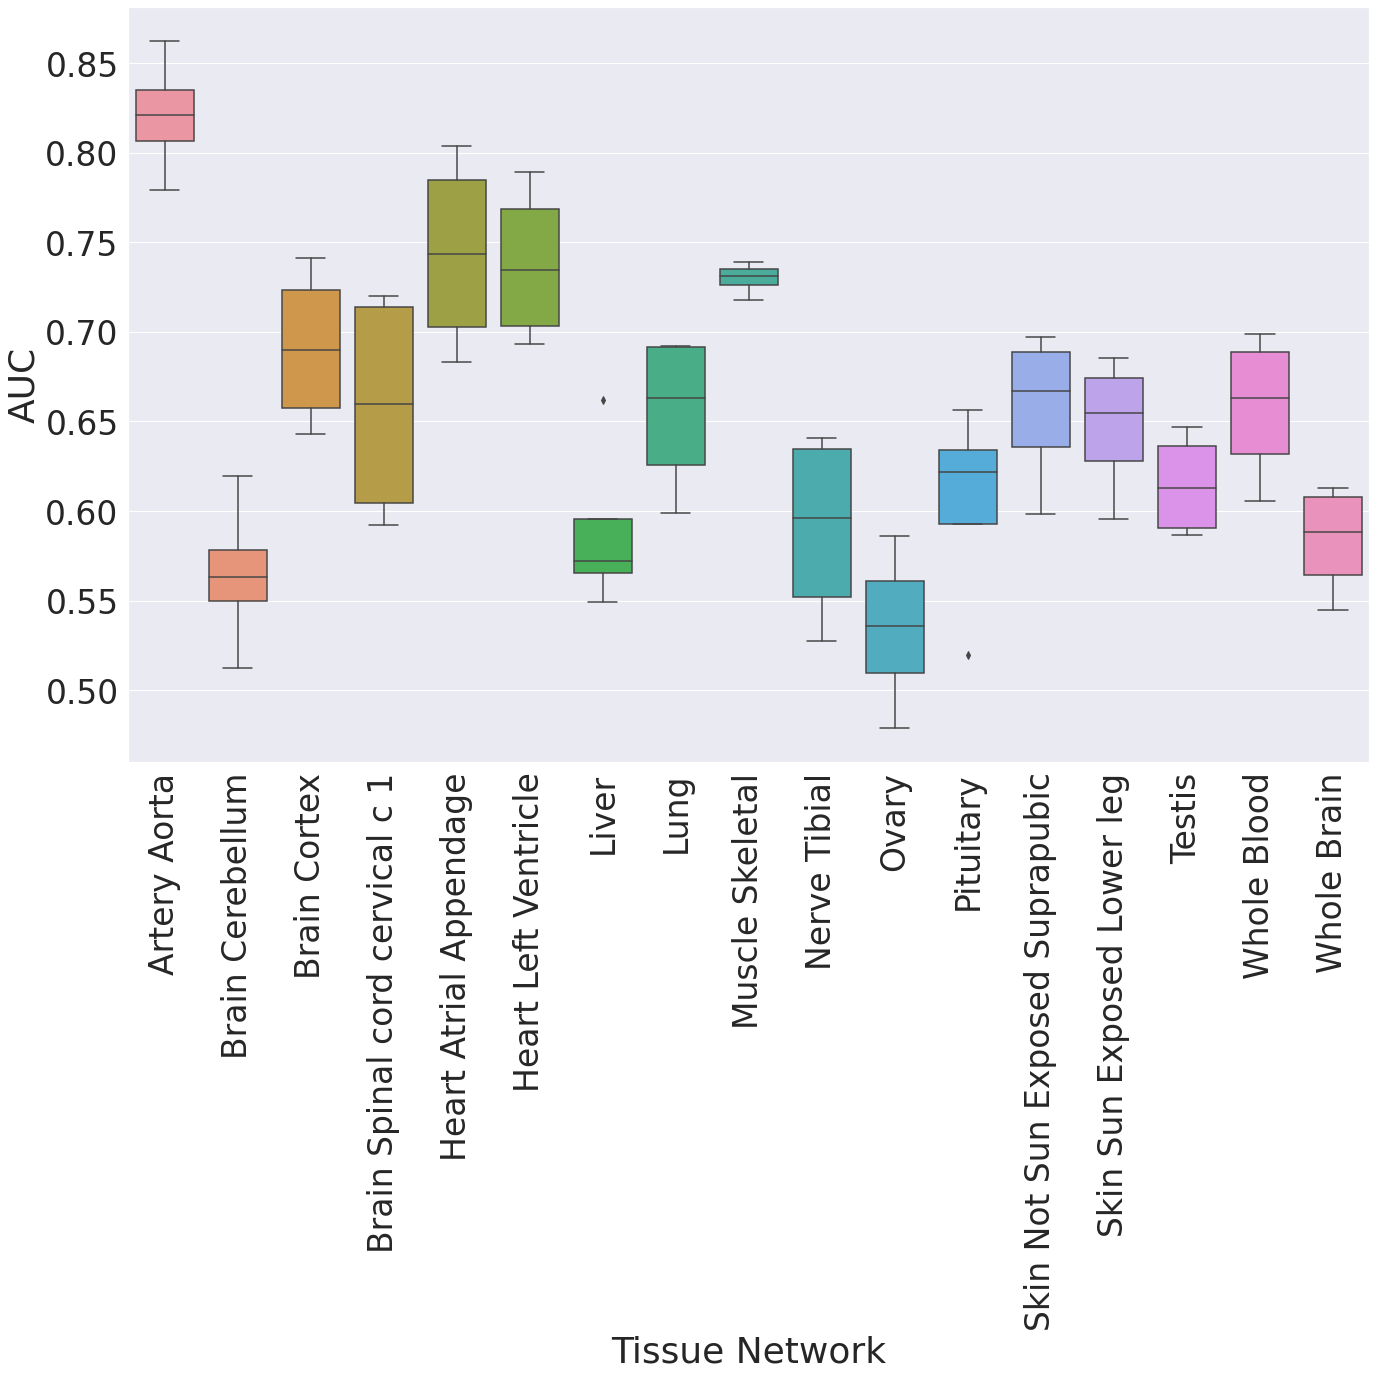

In [98]:
import matplotlib.pyplot as plt
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=res_df, y="auc", x="tissue_name", orient="v")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("AUC")
ax.set_xlabel("Tissue Network")
ax.figure.tight_layout()
ax.figure.savefig("figures/ppi_auc_tissue.png")

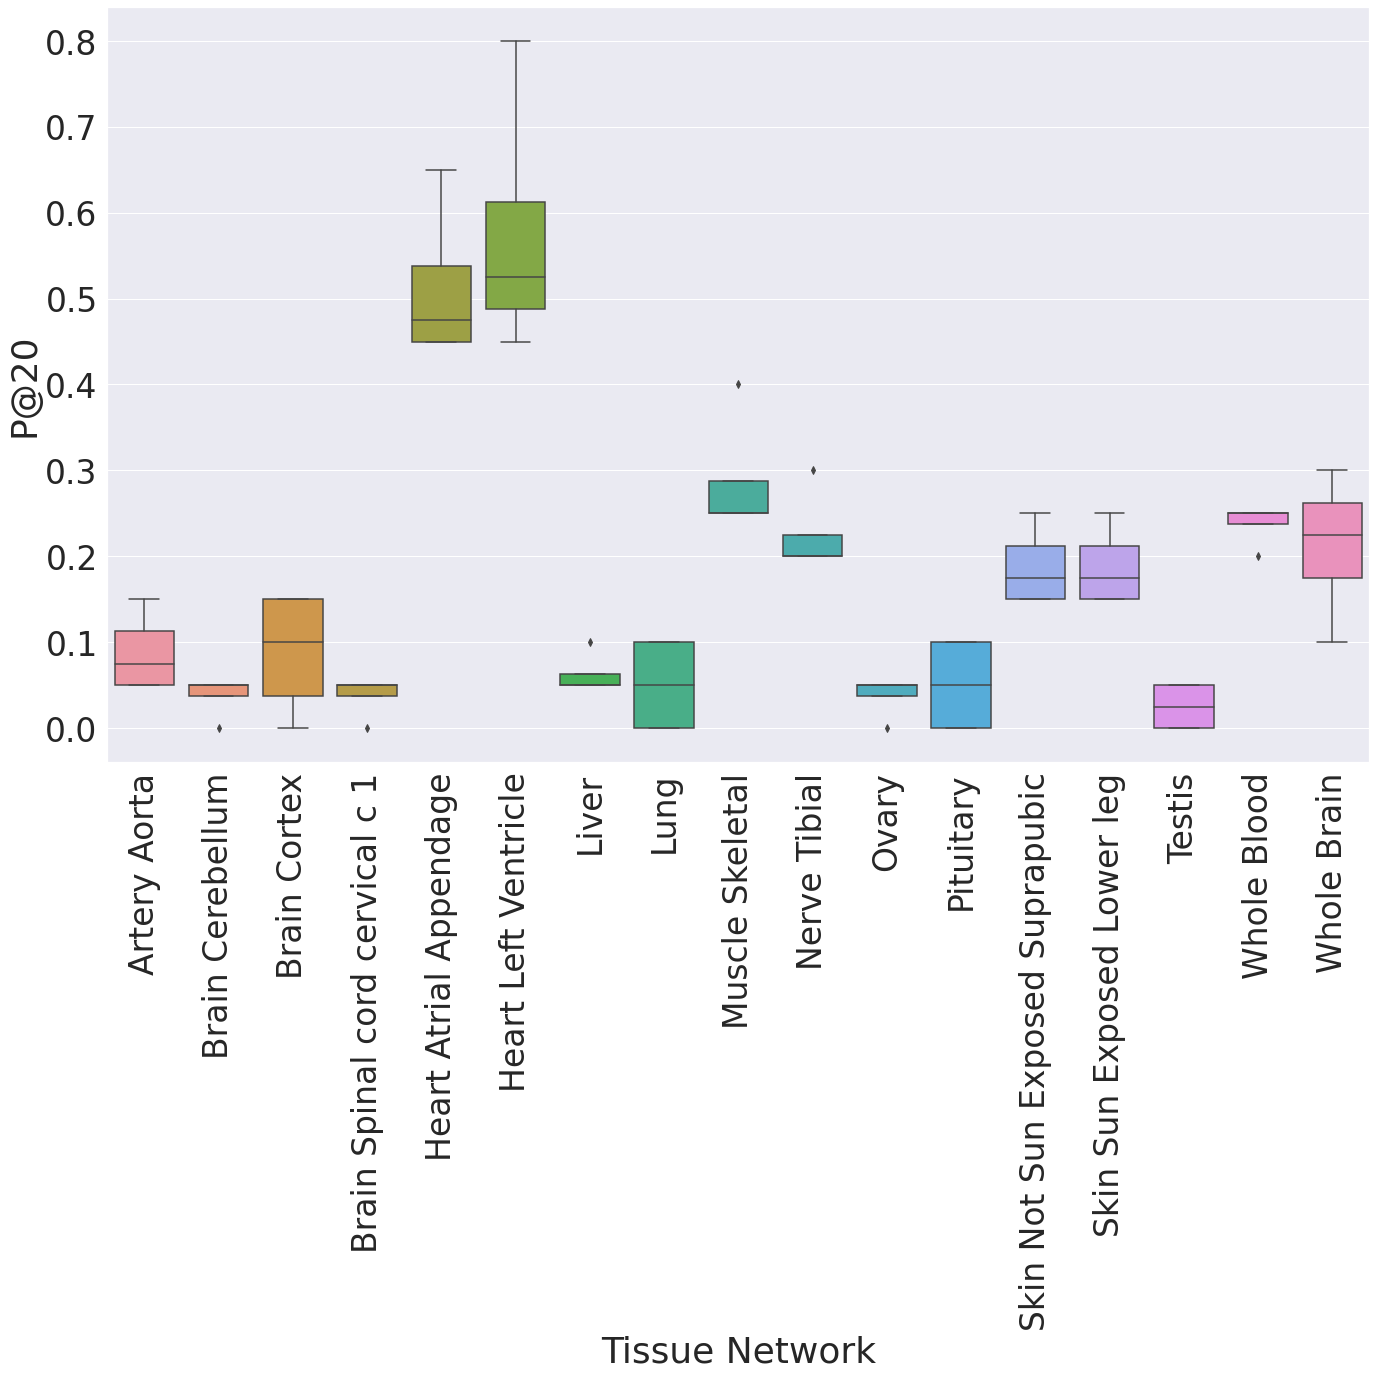

In [99]:
import matplotlib.pyplot as plt
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=res_df, y="p@20", x="tissue_name", orient="v")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("P@20")
ax.set_xlabel("Tissue Network")
ax.figure.tight_layout()
ax.figure.savefig("figures/ppi_p@20_tissue.png")

In [138]:
res_df.groupby("Method").median()

,auc,p@1,p@3,p@10,p@20,p@anom,anom,p@40
Method,,,,,,,,
Node2Vec + IForest,0.524405,0.0,0.000000,0.0,0.00,NaN,NaN,0.0
OddBall,0.602669,0.0,0.000000,0.0,0.00,NaN,NaN,NaN
WGAND (Ensemble),0.685079,1.0,0.333333,0.2,0.15,0.096000,101.0,NaN
WGAND (Feature`s Mean),0.691739,0.0,0.333333,0.1,0.15,0.080000,101.0,NaN
WGAND (IForest),0.598568,0.0,0.000000,0.1,0.10,0.086957,101.0,NaN
WGAND (PCA),0.639002,0.0,0.333333,0.1,0.15,0.080000,101.0,NaN


In [100]:
res_df = pd.concat([wgand, feature_comb, iforest, pca, oddball, baseline], ignore_index=True)


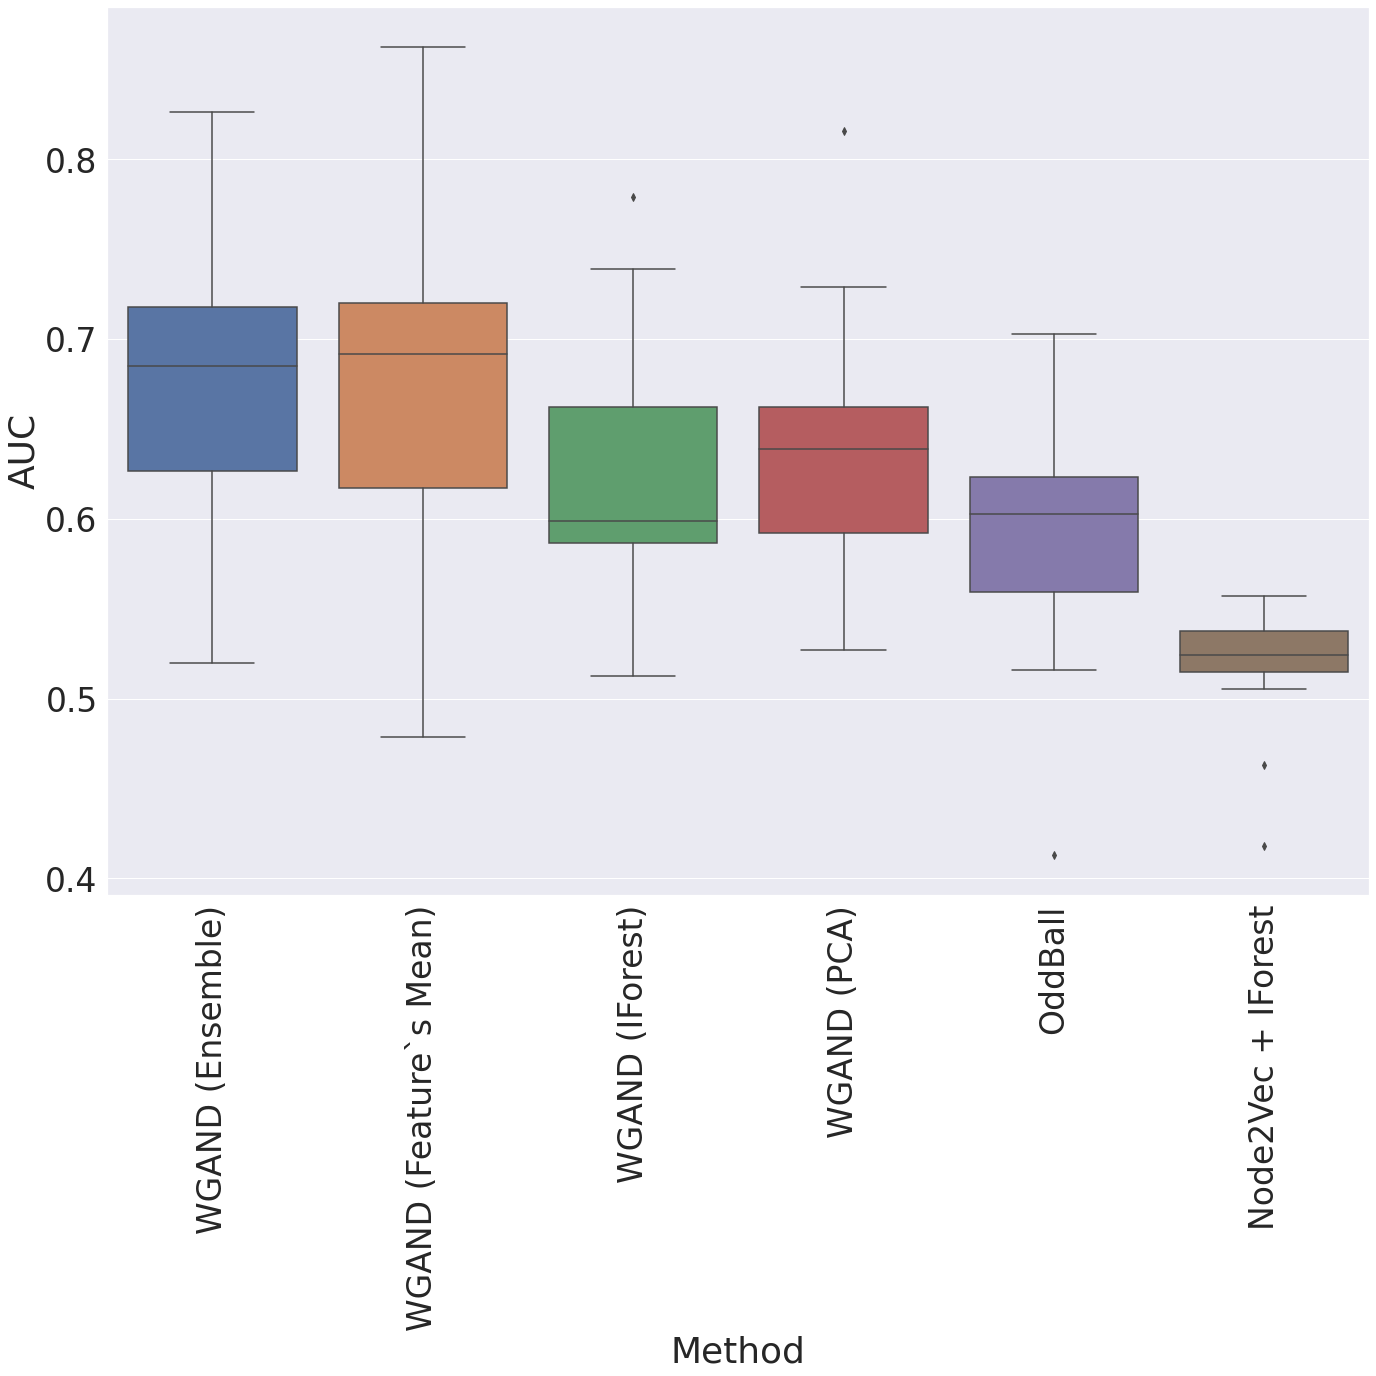

In [102]:
import matplotlib.pyplot as plt
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=res_df, y="auc", x="Method", orient="v")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("AUC")
# ax.set_xlabel("Tissue Network")
ax.figure.tight_layout()
ax.figure.savefig("figures/ppi_auc_clf.png")

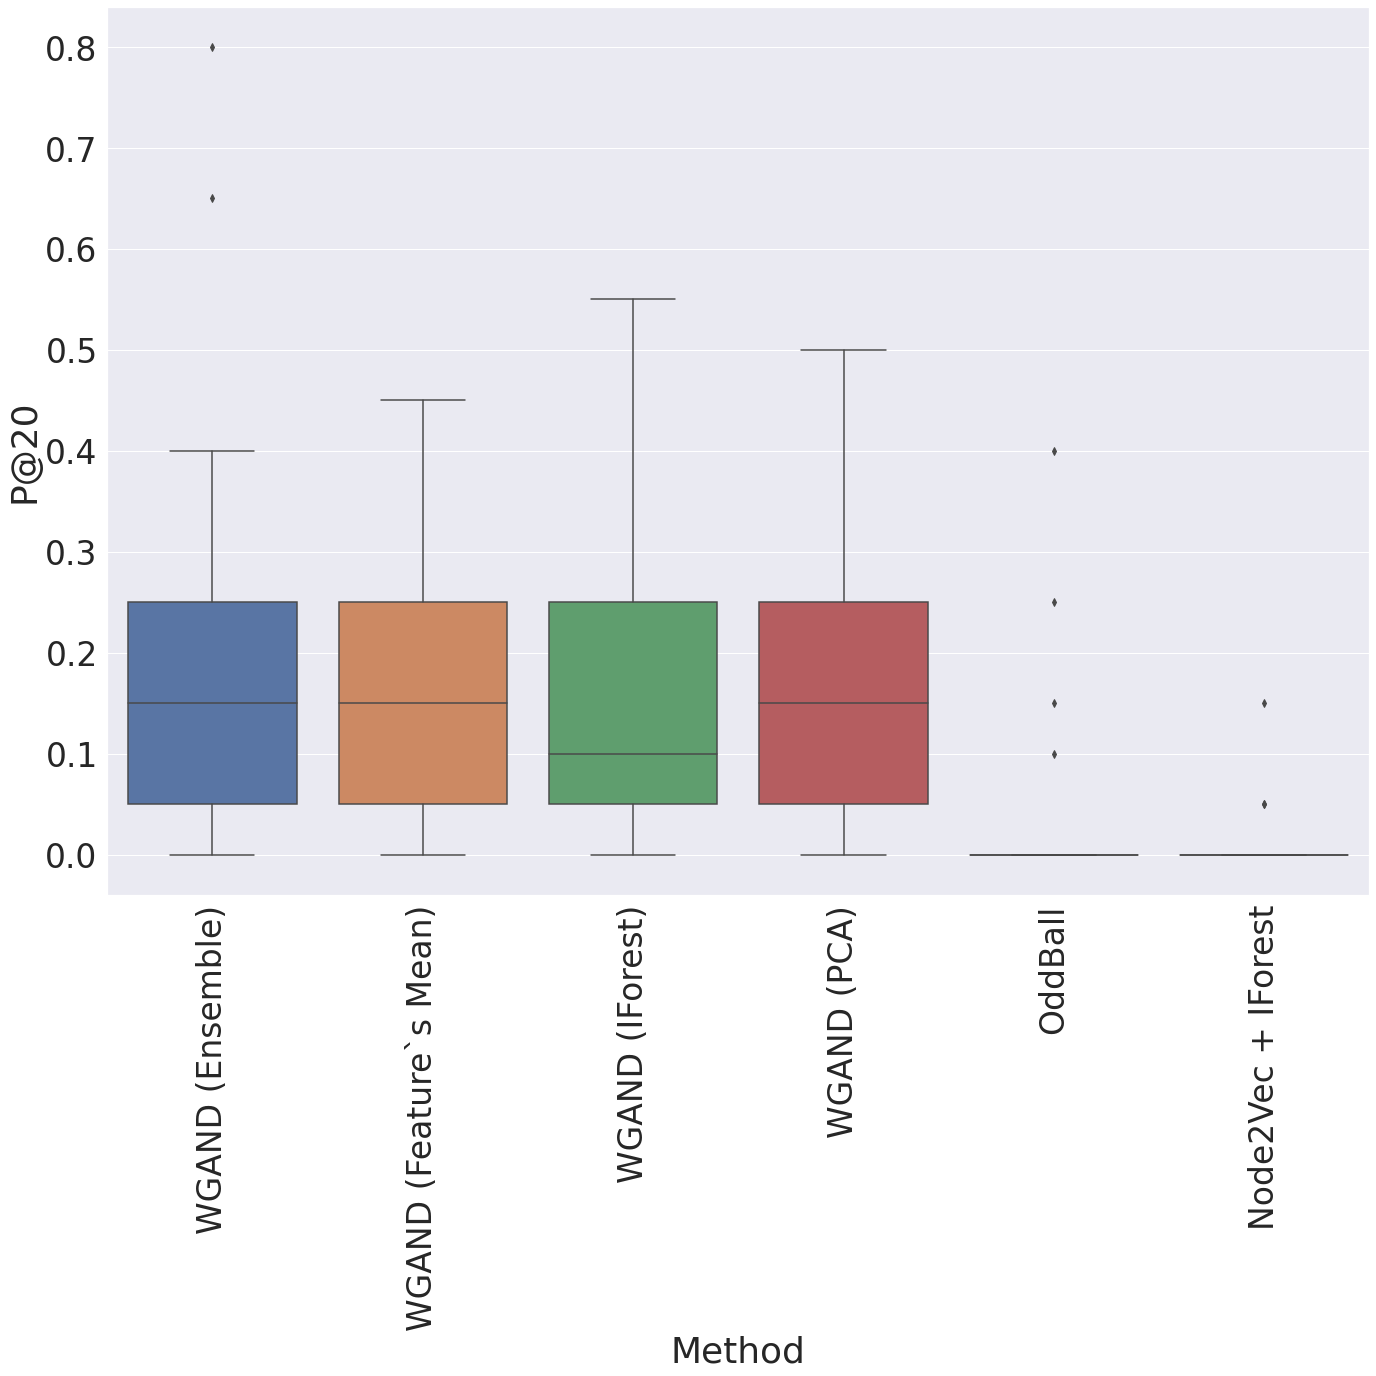

In [103]:
import matplotlib.pyplot as plt
sns.set(font_scale=3)
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=res_df, y="p@20", x="Method", orient="v")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("P@20")
ax.figure.tight_layout()
ax.figure.savefig("figures/ppi_p@20_clf.png")
# ax.set_xlabel("Tissue Network")

## PCA Scatter

  0%|          | 0/17 [00:00<?, ?it/s]

---------Skin Sun Exposed Lower leg-Skin--------


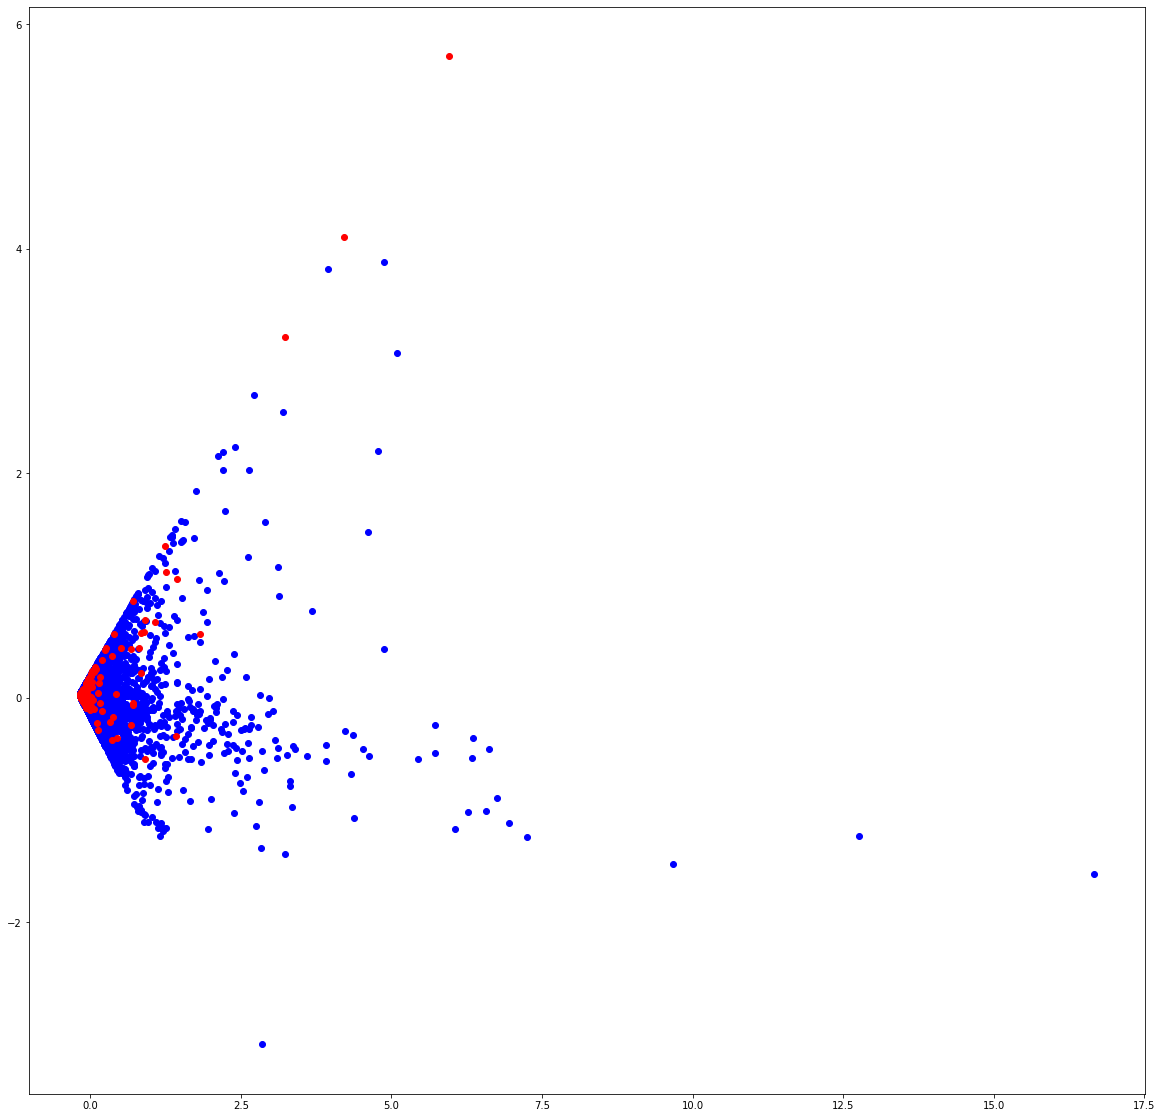

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for _, row in tqdm(tissue_mapping.iloc[13:14].iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

    nodes = list(g.nodes)
    y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]

    nad = PcaAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit()
    X = nad.get_node_training_data(nodes)
    X_pca = nad.pca_tran.transform(X)

    X_false = X_pca[np.array(y)==0]
    X_true = X_pca[np.array(y)==1]

(-1.2, 1.2)

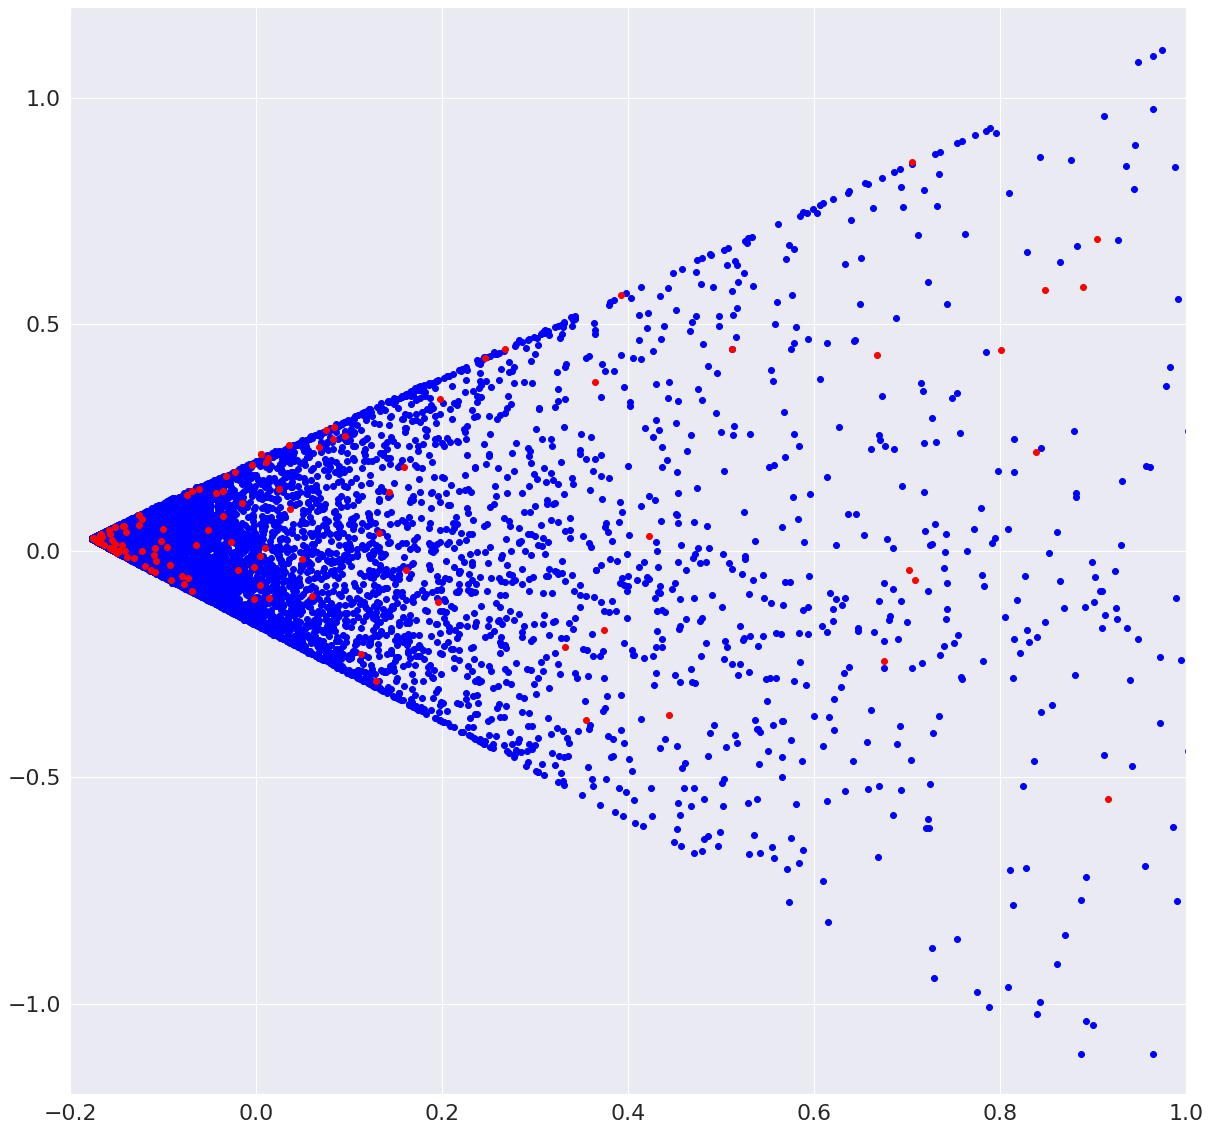

In [ ]:
sns.set_theme()
sns.set(font_scale=2)
plt.figure(figsize=(20,20))

plt.scatter(X_false[:,0], X_false[:,1],color="Blue")
plt.scatter(X_true[:,0], X_true[:,1], color="Red")
plt.xlim([-0.2, 1])
plt.ylim([-1.2, 1.2])
plt.savefig("figures/pca.png")

## Export to zip

In [13]:
!zip figures.zip figures/*

  adding: figures/p@k_clf.png (deflated 16%)
  adding: figures/p@k.png (deflated 12%)
  adding: figures/ppi_auc_clf.png (deflated 21%)
  adding: figures/ppi_auc_tissue.png (deflated 16%)
  adding: figures/ppi_p@20_clf.png (deflated 22%)
  adding: figures/ppi_p@20_tissue.png (deflated 16%)
